In [58]:
import cell2cell as c2c
import numpy as np
import pandas as pd

import tensorly as tl
from tensorly.decomposition import non_negative_tucker, non_negative_parafac 


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load Data

In [2]:
rnaseq_data = c2c.io.load_rnaseq('Celegans_Embryonic_RNASeqData_Warner.txt',
                                 gene_column='CommonName',
                                 drop_nangenes=True,
                                 log_transformation=False,
                                 format='csv',
                                 sep=','
                                )

Opening RNAseq datasets from Celegans_Embryonic_RNASeqData_Warner.txt
Celegans_Embryonic_RNASeqData_Warner.txt was correctly loaded


In [3]:
rnaseq_data.head()

,ceh32_T0,ceh32_T1,ceh32_T2,ceh32_T3,ceh32_T4,cnd1_T0,cnd1_T1,cnd1_T2,cnd1_T3,cnd1_T4,...,pha4_T0,pha4_T1,pha4_T2,pha4_T3,pha4_T4,tbx37_T0,tbx37_T1,tbx37_T2,tbx37_T3,tbx37_T4
CommonName,,,,,,,,,,,,,,,,,,,,,
aap-1,43.133459,50.658138,50.414970,35.766857,33.895195,58.599474,66.939721,61.222382,65.702870,47.982343,...,52.616365,60.825204,51.979991,43.455773,30.967278,51.326500,50.654093,49.112858,43.996665,33.075259
aat-1,1.621625,3.189402,9.831904,23.548271,22.726582,4.778361,11.748554,20.488394,23.204268,30.890648,...,6.237194,59.957473,130.003444,388.127157,433.615700,11.542751,15.744846,37.220783,102.917061,144.728664
aat-2,5.496731,12.937667,21.763256,29.827811,37.708772,12.952399,24.959862,25.108797,39.361573,44.727870,...,11.464360,41.773713,51.860603,57.235038,45.479755,7.449374,12.206810,18.608906,31.577895,37.431819
aat-3,61.400820,136.940807,198.831633,197.640775,219.688245,181.914836,260.822516,225.358789,303.181266,218.492232,...,111.998325,289.777602,288.678800,285.776295,186.243517,151.952176,203.938290,266.344493,303.632732,272.697353
aat-4,0.204774,1.159116,0.832428,0.591529,0.827419,0.285891,0.305862,0.466678,0.293390,0.913105,...,0.106712,0.948339,0.866276,1.472586,1.381153,0.406641,0.378540,0.714584,0.477434,0.734048


In [33]:
ppi_data = pd.read_excel('Celegans-Curated-LR-pairs.xlsx')

In [34]:
ppi_data = ppi_data.loc[(ppi_data['Ligand_symbol'].isin(rnaseq_data.index)) \
                        & (ppi_data['Receptor_symbol'].isin(rnaseq_data.index))]

In [35]:
ppi_data.sort_values(by='LR Function', inplace=True)

In [36]:
ppi_data.head()

,Ligand_WB,Receptor_WB,Ligand_symbol,Receptor_symbol,LR Function,L Function,R Function,Ligand_desc,Receptor_desc
242,WBGene00006444,WBGene00000415,shn-1,ced-1,Apoptosis,SH repeat,SREC,Is an ortholog of human SHANK1 (SH3 and multip...,Is an ortholog of human MEGF10 (multiple EGF l...
127,WBGene00001185,WBGene00001184,egl-17,egl-15,Canonical RTK-Ras-ERK signaling,FGF8,FGF-R,Is an ortholog of human FGF17 (fibroblast grow...,Is an ortholog of human FGFR1 (fibroblast grow...
39,WBGene00001185,WBGene00022418,egl-17,igcm-4,Canonical RTK-Ras-ERK signaling,FGF8,FGFR,Is an ortholog of human FGF17 (fibroblast grow...,Is an ortholog of human FGFRL1 (fibroblast gro...
165,WBGene00006787,WBGene00002299,unc-52,let-23,Canonical RTK-Ras-ERK signaling,Perlecan (secreted heparan sulfate proteoglycan),EGF-R,Is an ortholog of human HSPG2 (heparan sulfate...,Is an ortholog of human ERBB4 (erb-b2 receptor...
5,WBGene00002881,WBGene00004749,let-756,sdn-1,Canonical RTK-Ras-ERK signaling,FGF,Syndecan 1 (forms complexes with FGFR),Is an ortholog of human FGF16 (fibroblast grow...,Is an ortholog of human SDC1 (syndecan 1). Is ...


In [37]:
ppi_data.shape

(244, 9)

# Analysis

In [134]:
times = {'T0' : '120',
         'T1' : '210',
         'T2' : '300',
         'T3' : '390',
         'T4' : '480'
        }

In [135]:
markers = {'hlh1' : 'Muscles & Coelomocytes',
           'end1' : 'Intestine',
           'cnd1' : 'Neurons',
           'pha4' : 'Pharynx',
           'nhr25end1' : 'Hypodermis',
           'ceh32' : 'ABala-derived (Neurons & Glial Cells)',
           'tbx37' : 'ABa-derived (Neurons, Phrarynx & Hypodermis)'
          }

In [136]:
times = ['T0', 'T1', 'T2', 'T3', 'T4']
total_cells = list(set([x.split('_')[0] for x in rnaseq_data.columns]))

In [137]:
def plot_factors(factors, d=3, factor_labels = ["Time", "Features", "Time"]):
    assert d == len(factor_labels), "The lenght of factor_labels must match d"
    rank = factors[0].shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = factor_labels
    if rank > 1:
        for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
            axs[-1].set_xlabel(factors_name[ind])
            for i, (f, ax) in enumerate(zip(factor.T, axs)):
                sns.despine(top=True, ax=ax)
                ax.bar(range(len(f)),f)
                axes[i, 0].set_ylabel("Factor " + str(i+1))
    else:
        for ind, factor, in enumerate(factors[:d]):
            ax = axes[ind]
            ax.set_xlabel(factors_name[ind])
            for i, f in enumerate(factor.T):
                sns.despine(top=True, ax=ax)
                ax.bar(range(len(f)),f)
                ax.set_ylabel("Factor " + str(i+1))
    fig.tight_layout()

In [207]:
def generate_temporal_ccc_tensor(input_rnaseq,
                                 lr_pairs,
                                 times,
                                 cell_labels,
                                 ligand_col='Ligand_symbol',
                                 receptor_col='Receptor_symbol',
                                ):

    time_tensor = []

    for T in times:
        cell_time = [c + '_' + T for c in total_cells]
        ccc_tensor = []
        df = input_rnaseq[cell_time]
        for idx, lr in lr_pairs.iterrows():
            ligand_v = df.loc[lr[ligand_col],:].values
            receptor_v = df.loc[lr[receptor_col],:].values
            ccc_tensor.append(np.outer(ligand_v, receptor_v).tolist())
        time_tensor.append(ccc_tensor)
    return time_tensor

In [208]:
binary_rnaseq = rnaseq_data.gt(10).astype(float)
continuous_rnaseq = np.log2(rnaseq_data+1.0)

In [209]:
binary_tensor = generate_temporal_ccc_tensor(binary_rnaseq,
                                             ppi_data, 
                                             times, 
                                             total_cells,
                                            )

In [210]:
continuous_tensor = generate_temporal_ccc_tensor(continuous_rnaseq,
                                                 ppi_data, 
                                                 times, 
                                                 total_cells,
                                                )

In [214]:
tl_b_tensor = tl.tensor(binary_tensor)

In [215]:
tl_c_tensor = tl.tensor(continuous_tensor)

In [216]:
r = 7

In [217]:
b_cp_tf = non_negative_parafac(tl_b_tensor,
                               r,
                               normalize_factors=False
                              )

In [218]:
b_tucker_tf = non_negative_tucker(tl_b_tensor,
                                [r, r, r, r]
                               )

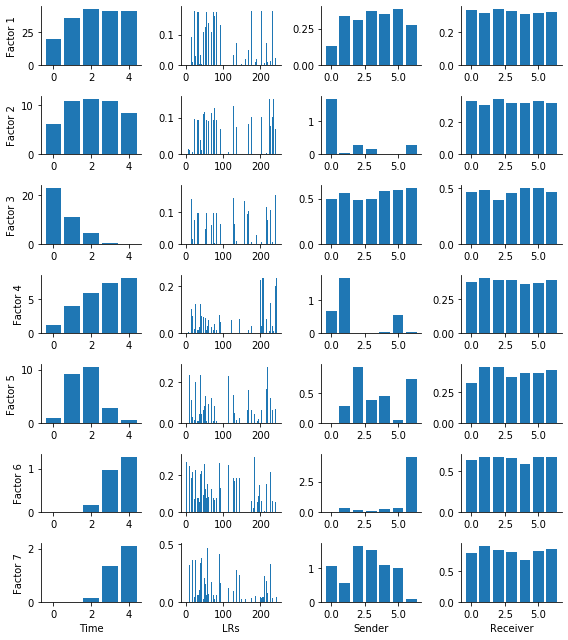

In [219]:
plot_factors(b_cp_tf.factors, d=4, factor_labels=['Time', 'LRs', 'Sender', 'Receiver'])

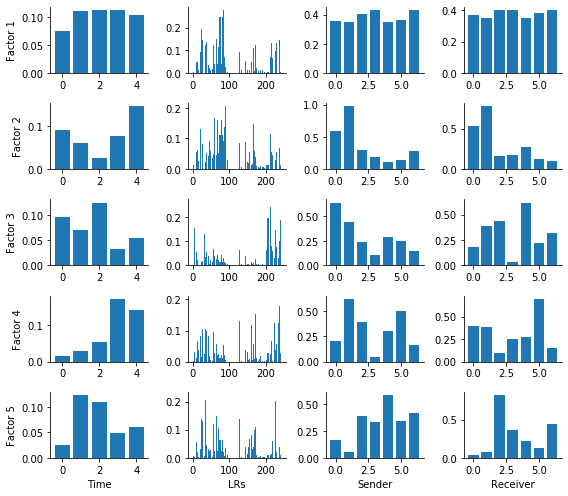

In [220]:
plot_factors(b_tucker_tf.factors, d=4, factor_labels=['Time', 'LRs', 'Sender', 'Receiver'])

In [222]:
c_cp_tf = non_negative_parafac(tl_c_tensor,
                               r,
                               normalize_factors=False
                              )

In [223]:
c_tucker_tf = non_negative_tucker(tl_c_tensor,
                                [r, r, r, r]
                               )

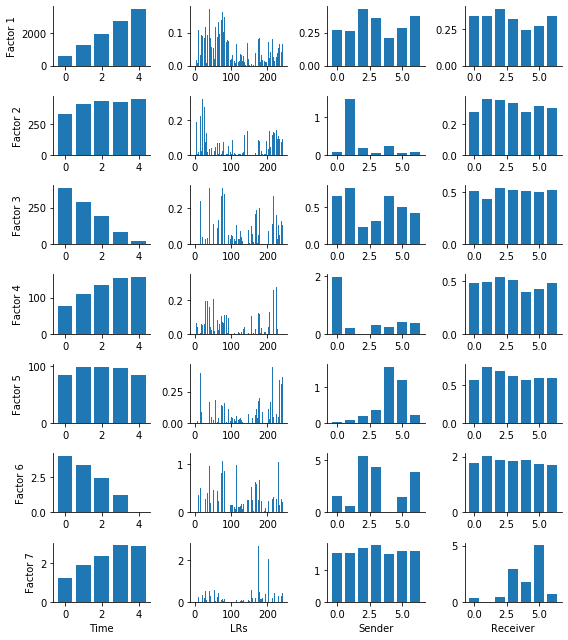

In [224]:
plot_factors(c_cp_tf.factors,
             d=4,
             factor_labels=['Time', 'LRs', 'Sender', 'Receiver']
            )

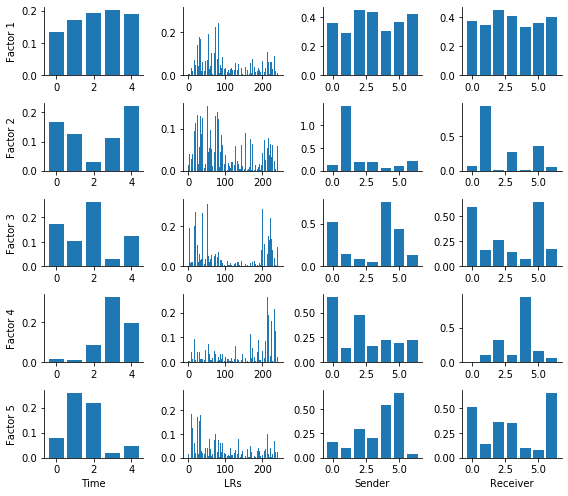

In [225]:
plot_factors(c_tucker_tf.factors,
             d=4, 
             factor_labels=['Time', 'LRs', 'Sender', 'Receiver']
            )

In [201]:
[markers[c] for c in total_cells]

['Hypodermis',
 'Muscles & Coelomocytes',
 'Neurons',
 'ABa-derived (Neurons, Phrarynx & Hypodermis)',
 'Intestine',
 'Pharynx',
 'ABala-derived (Neurons & Glial Cells)']

In [203]:
ppi_data['LR Function'].values.tolist()

['Apoptosis',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Canonical RTK-Ras-ERK signaling',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesion',
 'Cell adhesio